In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import matplotlib.pyplot as plt
import torch
from visualizer import visualize_random_image, visualize_loss_acc_plot
from train import setup_train_args, build, test

/home/droneresearch/student_teacher/Models/pvt_v2.py:331: UserWarning: Overwriting pvt_v2_b0 in registry with Models.pvt_v2.pvt_v2_b0. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/home/droneresearch/student_teacher/Models/pvt_v2.py:342: UserWarning: Overwriting pvt_v2_b1 in registry with Models.pvt_v2.pvt_v2_b1. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/home/droneresearch/student_teacher/Models/pvt_v2.py:353: UserWarning: Overwriting pvt_v2_b2 in registry with Models.pvt_v2.pvt_v2_b2. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/home/droneresearch/student_teacher/Models/pvt_v2.py:363: UserWarning: Overwriting pvt_v2_b3 in registry with Models.pvt_v2.pvt_v2_b3. This is because the name being registered conflicts with an existin

In [2]:
datasets = ["Kvasir", "CVC", "both"]
dataset = datasets[2]

In [3]:
from train import student_train_epoch
def train_student_with_teach(args, unet_size):
    (device,
     train_dataloader,
     test_dataloader,
     val_dataloader,
     Dice_loss,
     BCE_loss,
     KLT_loss,
     perf,
     student_model,
     teach_model,
     optimizer,
     alpha,
     temperature) = build(args)

    loss_storage = []
    # performance metric is dice score
    perf_storage = []

    if not os.path.exists("./Trained_student_models/trained_with_teacher/"):
        os.makedirs("./Trained_student_models/trained_with_teacher/")

    model_name = student_model.__class__.__name__
    my_path = f"Trained_student_models/trained_with_teacher/{model_name}{unet_size}128_temp_{temperature}_alpha_{alpha}_lr_{args_train_student.lr}" + args.dataset
    prev_best_test = None
    if args.lrs == "true":
        if args.lrs_min > 0:
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="max", factor=0.5, min_lr=args.lrs_min, verbose=True, patience=6
            )
        else:
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="max", factor=0.5, verbose=True, patience=6
            )
    for epoch in range(1, args.epochs + 1):
        try:
            loss = student_train_epoch(student_model, teach_model, device, train_dataloader,
                                       optimizer, epoch, Dice_loss, BCE_loss, KLT_loss, temperature, alpha)

            test_measure_mean, test_measure_std = test(
                student_model, device, val_dataloader, epoch, perf
            )
            # add means and loss for vis
            loss_storage.append(loss)
            perf_storage.append(test_measure_mean)

        except KeyboardInterrupt:
            print("Training interrupted by user")
            sys.exit(0)
        if args.lrs == "true":
            scheduler.step(test_measure_mean)
        # if prev_best_test == None or test_measure_mean > prev_best_test:
        #     print("Saving...")
        #     # torch.save(
        #     #     {
        #     #         "epoch": epoch,
        #     #         "model_state_dict": student_model.state_dict()
        #     #         if args.mgpu is False
        #     #         else student_model.module.state_dict(),
        #     #         "optimizer_state_dict": optimizer.state_dict(),
        #     #         "loss": loss,
        #     #         "test_measure_mean": test_measure_mean,
        #     #         "test_measure_std": test_measure_std,
        #     #     },
        #     #     my_path + ".pt",
        #     # )
        #     prev_best_test = test_measure_mean
        if epoch % 10 == 1: 
            visualize_random_image(test_dataloader, student_model)
    return loss_storage, perf_storage, my_path

UNet(
  (normalize): Normalize()
  (downs): ModuleList(
    (0): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runnin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


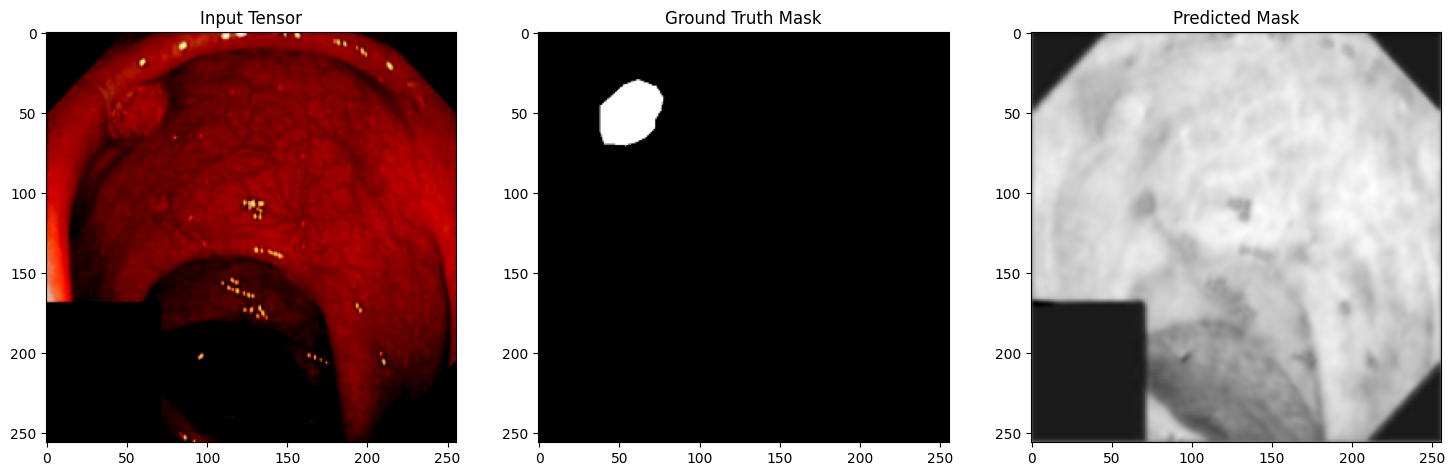

Train Epoch: 2 [1288/1290 (100.0%)]	Average loss: 39.023765	Time: 21.646280
Test  Epoch: 2 [161/161 (100.0%)]	Average performance: 0.329905	Time: 0.997761
Train Epoch: 3 [1288/1290 (100.0%)]	Average loss: 38.692470	Time: 21.713536
Test  Epoch: 3 [161/161 (100.0%)]	Average performance: 0.336335	Time: 1.015502
Training interrupted by user


AttributeError: 'tuple' object has no attribute 'tb_frame'

In [4]:
args_train_student = setup_train_args(my_model="unet128", temperature=8, alpha=0.9, dataset=dataset,
                                      data_root="./data_root/", batch_size=8, epochs=100, learning_rate=0.001)
losses, perfs, path = train_student_with_teach(args_train_student, 128)
visualize_loss_acc_plot(losses, acc_list=perfs, path=path + ".png")

In [ ]:
args_train_student = setup_train_args(my_model="unet128", temperature=8, alpha=0.99, dataset=dataset,
                                      data_root="./data_root/", batch_size=8, epochs=100, learning_rate=0.001)
losses, perfs, path = train_student_with_teach(args_train_student, 128)
visualize_loss_acc_plot(losses, acc_list=perfs, path=path + ".png")

In [ ]:
args_train_student = setup_train_args(my_model="unet128", temperature=3, alpha=0.9, dataset=dataset,
                                      data_root="./data_root/", batch_size=8, epochs=100, learning_rate=0.001)
losses, perfs, path = train_student_with_teach(args_train_student, 128)
visualize_loss_acc_plot(losses, acc_list=perfs, path=path + ".png")

In [ ]:
args_train_student = setup_train_args(my_model="unet128", temperature=3, alpha=0.99, dataset=dataset,
                                      data_root="./data_root/", batch_size=8, epochs=100, learning_rate=0.001)
losses, perfs, path = train_student_with_teach(args_train_student, 128)
visualize_loss_acc_plot(losses, acc_list=perfs, path=path + ".png")

In [ ]:
args_train_student = setup_train_args(my_model="unet128", temperature=8, alpha=0.3, dataset=dataset,
                                      data_root="./data_root/", batch_size=8, epochs=100, learning_rate=0.001)
losses, perfs, path = train_student_with_teach(args_train_student, 128)
visualize_loss_acc_plot(losses, acc_list=perfs, path=path + ".png")

In [42]:
args_train_student = setup_train_args(my_model="unet128", temperature=3, alpha=0.3, dataset=dataset,
                                      data_root="./data_root/", batch_size=8, epochs=100, learning_rate=0.001)
losses, perfs, path = train_student_with_teach(args_train_student, 128)
visualize_loss_acc_plot(losses, acc_list=perfs, path=path + ".png")

TypeError: train_student_with_teach() takes 1 positional argument but 2 were given

In [ ]:
args_train_student = setup_train_args(my_model="unet512", temperature=8, alpha=0.9, dataset=dataset,
                                      data_root="./data_root/", batch_size=8, epochs=100, learning_rate=0.001)
losses, perfs, path = train_student_with_teach(args_train_student, 512)
visualize_loss_acc_plot(losses, acc_list=perfs, path=path + ".png")

In [ ]:
args_train_student = setup_train_args(my_model="unet512", temperature=8, alpha=0.99, dataset=dataset,
                                      data_root="./data_root/", batch_size=8, epochs=100, learning_rate=0.001)
losses, perfs, path = train_student_with_teach(args_train_student, 512)
visualize_loss_acc_plot(losses, acc_list=perfs, path=path + ".png")

In [ ]:
args_train_student = setup_train_args(my_model="unet512", temperature=8, alpha=0.3, dataset=dataset,
                                      data_root="./data_root/", batch_size=8, epochs=100, learning_rate=0.001)
losses, perfs, path = train_student_with_teach(args_train_student, 512)
visualize_loss_acc_plot(losses, acc_list=perfs, path=path + ".png")

In [ ]:
args_train_student = setup_train_args(my_model="unet512", temperature=3, alpha=0.3, dataset=dataset,
                                      data_root="./data_root/", batch_size=8, epochs=100, learning_rate=0.001)
losses, perfs, path = train_student_with_teach(args_train_student, 512)
visualize_loss_acc_plot(losses, acc_list=perfs, path=path + ".png")

In [ ]:
args_train_student = setup_train_args(my_model="unet512", temperature=3, alpha=0.99, dataset=dataset,
                                      data_root="./data_root/", batch_size=8, epochs=100, learning_rate=0.001)
losses, perfs, path = train_student_with_teach(args_train_student, 512)
visualize_loss_acc_plot(losses, acc_list=perfs, path=path + ".png")

In [ ]:
args_train_student = setup_train_args(my_model="unet512", temperature=3, alpha=0.9, dataset=dataset,
                                      data_root="./data_root/", batch_size=8, epochs=100, learning_rate=0.001)
losses, perfs, path = train_student_with_teach(args_train_student, 512)
visualize_loss_acc_plot(losses, acc_list=perfs, path=path + ".png")